In [11]:
import sys
import os
import datetime
import random

import numpy as np
import pandas as pd
import copy

import torch
from torch_geometric.data import Data

import wandb

import MDAnalysis
from MDAnalysis.analysis.distances import distance_array

import networkx as nx

from tqdm import tqdm

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))


## Build Dataset

In [13]:
reference = gumpy.Genome('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk')
pnca = reference.build_gene('pncA')

In [14]:
# recreate train/test dataset from pncA paper
pnca_paper_dataset = pd.read_csv('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/ds-traintest-phen.csv')
pnca_paper_dataset.CONSISTENT_PHENOTYPE.value_counts()

CONSISTENT_PHENOTYPE
R    349
S    315
Name: count, dtype: int64

In [15]:
def split_mutation(row):
    return pd.Series([row.MUTATION[0], int(row.MUTATION[1:-1]), row.MUTATION[-1]])

pnca_paper_dataset[['REF','AMINO_ACID','ALT']] = pnca_paper_dataset.apply(split_mutation,axis=1)

pnca_paper_dataset.head(10)

,MUTATION,CONSISTENT_PHENOTYPE,REF,AMINO_ACID,ALT
0,A102V,S,A,102,V
1,A134D,S,A,134,D
2,A134P,R,A,134,P
3,A134S,S,A,134,S
4,A134V,R,A,134,V
5,A143D,R,A,143,D
6,A143G,R,A,143,G
7,A143V,S,A,143,V
8,A146E,R,A,146,E
9,A146S,R,A,146,S


In [16]:
# create table of sample alleles

sequences = pd.DataFrame(columns=['phenotype_label','number_resistant_mutations', 'number_susceptible_mutations', 'allele'])

for idx, row in pnca_paper_dataset.iterrows():
    
    sample = copy.deepcopy(pnca)
    # reassign amino acid to mutated amino acid
    sample.amino_acid_sequence[sample.amino_acid_number==row.AMINO_ACID] = row.ALT
    
    sequence = ''.join(i for i in sample.amino_acid_sequence)
    
    if row.CONSISTENT_PHENOTYPE == 'R':
        number_resistant_mutations = 1
        number_susceptible_mutations = 0
        phenotype_label = 'R'
    else:
        number_resistant_mutations = 0
        number_susceptible_mutations = 1
        phenotype_label = 'S'
        
    sequences.loc[len(sequences)] = [phenotype_label, number_resistant_mutations, number_susceptible_mutations, sequence]
    

In [17]:
display(sequences)
display(sequences.phenotype_label.value_counts())

,phenotype_label,number_resistant_mutations,number_susceptible_mutations,allele
0,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
1,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
2,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
3,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
4,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
...,...,...,...,...
659,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
660,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
661,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
662,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...


phenotype_label
R    349
S    315
Name: count, dtype: int64

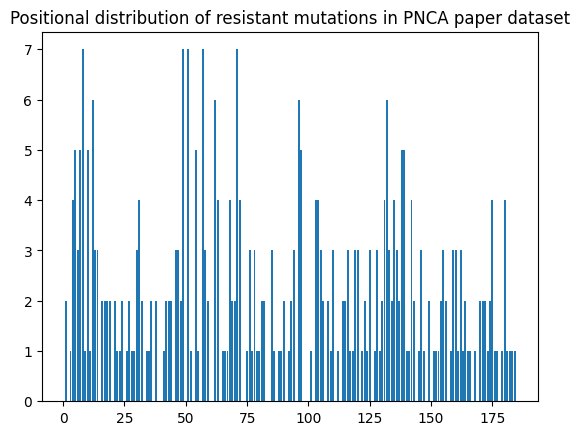

In [8]:
from matplotlib import pyplot as plt

data = pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='R']['AMINO_ACID'].value_counts()

plt.bar(data.index, data.values)
plt.title('Positional distribution of resistant mutations in PNCA paper dataset')
plt.show()

# Resistant mutations are spread widely across the protein;
# model may be having hard time distinguishing 

## 2. Create synthetic dataset

Use mutations from dataset from pncaA paper, and create with SBMLSim

In [18]:
# reduce list of resistant and susceptible mutations to only those with unique amino acid positions

s_pos = list(pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='S'].AMINO_ACID.drop_duplicates())
r_pos = list(pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='R'].AMINO_ACID.drop_duplicates())

distinct_s = [pos for pos in s_pos if pos not in r_pos]
distinct_r = [pos for pos in r_pos if pos not in s_pos]
print('Number distinct resistant positions:', len(distinct_r))
print('Number distinct susceptible positions:', len(distinct_s))

Number distinct resistant positions: 37
Number distinct susceptible positions: 38


In [19]:
res_muts = pnca_paper_dataset[pnca_paper_dataset['AMINO_ACID'].isin(distinct_r)]['MUTATION']
resistant_list = list(set(res_muts))

sus_muts = pnca_paper_dataset[pnca_paper_dataset['AMINO_ACID'].isin(distinct_s)]['MUTATION']
susceptible_list = list(set(sus_muts))
print('Number distinct resistant mutations:', len(resistant_list))
print('Number distinct susceptible mutaitons:', len(susceptible_list))

Number distinct resistant mutations: 148
Number distinct susceptible mutaitons: 107


In [20]:
resistant_list = ['pncA@' + x for x in resistant_list]
susceptible_list = ['pncA@' + x for x in susceptible_list]

In [21]:
# use sbmlsim

batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations=resistant_list,
                        susceptible_mutations= susceptible_list,
                        genbank_file='/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk'
                    )

In [22]:
seed = 55
np.random.seed(seed)
random.seed(seed)

n_samples = 5000

synth_sequences, synth_mutations = batch.generate(n_samples=n_samples,
                                                  proportion_resistant=0.5,
                                                  n_res = 1,
                                                  n_sus = 1)

synth_sequences.rename(columns = {'pncA':'allele'}, inplace=True)

In [23]:
synth_sequences

,phenotype_label,number_resistant_mutations,number_susceptible_mutations,allele
sample_id,,,,
0,R,2,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
1,S,0,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
2,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
3,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
4,R,3,1,MRALIIVDVQNDFCEGGSLAVTGGAALARASSDYLAEAADYHHVVA...
...,...,...,...,...
4995,R,1,1,MRALIIVDVQNDICEGGSLAVTGGTALARAISDYLAEAADYHHVVA...
4996,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
4997,R,1,1,MRALIIVDVQNDFCEGGSLAVTGVAALARAISDYLAEAADYHHVVA...


## Build adjacency matrix

In [12]:
def build_resids(sequence):
    resids = []
    counter=1
    for i in sequence:
        if counter<=185:
            resids.append(('A',i,counter))
            counter+=1
    return np.array(resids)

In [13]:
cutoff_distance = 6.3  

protein_structure = MDAnalysis.Universe('../pdb/3PL1-PZA.pdb')

# subset down to the protein alone
# almost "sidechain" but have to keep CA for GLY 
nodes = protein_structure.select_atoms('protein and not name C N O')

# FIXME: need alternative ways of calculating the distance matrix e.g. minimum distance between atoms
# the compound command aggregates by residue so the distance_array is resid i to resid j
d_array = distance_array(nodes.center_of_mass(compound='residues'), nodes.center_of_mass(compound='residues'), backend='OpenMP')

# convert to Boolean
mask = d_array < cutoff_distance

# convert to correct form for PyTorch Geometric
edges = np.argwhere(mask)
edge_index = torch.tensor(edges.transpose(), dtype=torch.long)
edge_index


tensor([[  0,   0,   0,  ..., 184, 184, 184],
        [  0, 123, 124,  ..., 158, 183, 184]])

In [14]:
# test without self loops
from torch_geometric.utils import remove_self_loops

edge_index = remove_self_loops(edge_index)[0]
edge_index

tensor([[  0,   0,   0,  ..., 184, 184, 184],
        [123, 124, 125,  ..., 157, 158, 183]])

## Create features

In [15]:
# distance feature and stride

wildtype,mutations = batch.generate(1,0.0, n_res=0, n_sus=0)
seq = wildtype.allele[0][:185]
resids = build_resids(seq)
df = pd.DataFrame(resids, columns=['segid', 'amino_acid', 'resid'])
df.resid = df.resid.astype('int')
distances = sbmlcore.FeatureDataset(df,species='M. tuberculosis', gene='pncA', protein='PncA')

d = sbmlcore.StructuralDistances('../pdb/3PL1-PZA.pdb', 'resname PZA', 'PZA_dist', infer_masses=False, dataset_type='amino_acid')

distances.add_feature([d])
stride = sbmlcore.Stride('../pdb/3PL1-PZA.pdb', dataset_type='amino_acid')
distances.add_feature([stride])
distances.df.set_index(['segid','resid'],inplace=True)
distances.df

amino_acid   PZA_dist secondary_structure  \
segid resid                                             
A     1              M  27.641663                   C   
      2              R  24.722696                   E   
      3              A  21.557456                   E   
      4              L  18.780048                   E   
      5              I  15.158482                   E   
...                ...        ...                 ...   
      181            E  21.844889                   E   
      182            L  20.530870                   E   
      183            V  22.453640                   E   
      184            C  22.603351                   C   
      185            S  22.750537                   C   

            secondary_structure_long     phi     psi  residue_sasa  \
segid resid                                                          
A     1                         Coil    0.00  -35.20          86.2   
      2                       Strand -117.94  133.99          54.7   
      3                       Strand -126.53  153.85           0.0   
      4                       Strand -103.24  132.40           0.2   
      5                       Strand -113.70  111.88           0.2   
...                              ...     ...     ...           ...   
      181                     Strand  -91.73  121.85         105.5   
      182                     Strand -106.70  110.91          50.6   
      183                     Strand -134.36  166.85          33.8   
      184                       Coil  -92.41  154.12          95.4   
      185                       Coil  -73.76    0.00          67.6   

             n_hbond_acceptors  n_hbond_donors      B      C      E      G  \
segid resid                                                                  
A     1                    2.0             0.0  False   True  False  False   
      2                    2.0             0.0  False  False   True  False   
      3                    1.0             1.0  False  False   True  False   
      4                    1.0             1.0  False  False   True  False   
      5                    1.0             1.0  False  False   True  False   
...                        ...             ...    ...    ...    ...    ...   
      181                  1.0             1.0  False  False   True  False   
      182                  0.0             0.0  False  False   True  False   
      183                  1.0             1.0  False  False   True  False   
      184                  0.0             0.0  False   True  False  False   
      185                  0.0             0.0  False   True  False  False   

                 H      T  
segid resid                
A     1      False  False  
      2      False  False  
      3      False  False  
      4      False  False  
      5      False  False  
...            ...    ...  
      181    False  False  
      182    False  False  
      183    False  False  
      184    False  False  
      185    False  False  

[185 rows x 15 columns]

In [16]:
# build rest of features

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

def build_feature_dataframe(resids, distances):

    df = pd.DataFrame(resids, columns=['segid', 'amino_acid', 'resid'])
    df.resid = df.resid.astype('int')
    features = sbmlcore.FeatureDataset(df,species='M. tuberculosis', gene='pncA', protein='PncA')

    v = sbmlcore.AminoAcidVolume()
    h = sbmlcore.AminoAcidHydropathyWimleyWhite()
    mw = sbmlcore.AminoAcidMW()
    p = sbmlcore.AminoAcidPi()
    kd = sbmlcore.AminoAcidHydropathyKyteDoolittle()
    ha = sbmlcore.HBondAcceptors()
    hd = sbmlcore.HBondDonors()
    r = sbmlcore.SideChainRings()
    # d = sbmlcore.StructuralDistances('pdb/3PL1-PZA.pdb', 'resname PZA', 'PZA_dist', infer_masses=False, dataset_type='amino_acid')
    features.add_feature([v, h, mw, p, kd, ha, hd, r])

    for col in ['volume', 'hydropathy_WW', 'Pi', 'MW', 'hydropathy_KD', 'h_acceptors', 'h_donors', 'rings']:
        features.df[col] = features.df[col].astype('float') 

    features.df.set_index(['segid', 'resid'], inplace=True)
    features.df = features.df.join(distances[['PZA_dist', 'phi', 'psi', 'residue_sasa']], on=['segid', 'resid'], how='inner')
    features.df.reset_index(inplace=True)
    features.df['PZA_dist'] = features.df['PZA_dist'].astype('float') 
    # print(features.df)
    # print(numpy.array(features.df))
    
    features.df = features.df.sort_values(by='resid', ascending=True)
    
    x = np.array(features.df)[:,3:]

    transformer = MinMaxScaler().fit(x)

    x = transformer.transform(x)

    x = torch.tensor(x.tolist(), dtype=torch.float)

    return x


## Create Data objects

In [17]:
def create_dataset(sequences):
    dataset = []
    
    for idx,row in tqdm(sequences.iterrows(), total=len(sequences)):

        resids = build_resids(row.allele[:185])

        x = build_feature_dataframe(resids, distances.df)

        y = torch.tensor(1 if row.phenotype_label == "R" else 0)

        data = Data(x=x, edge_index=edge_index, y=y, device="mps")

        assert data.validate(raise_on_error=True)

        dataset.append(data)
    
    return dataset

## Test run

In [18]:
# dataset = create_dataset(synth_sequences)

In [19]:
def simple_gcn(
    dataset,
    # batch: sbmlsim.Batch,
    # n_samples,
    # prop_resistant,
    # n_res,
    # n_sus,
    # self_loops,
    # cutoff_distance,
    batch_size,
    num_node_features,
    hidden_channels,
    learning_rate,
    wd,
    epochs,
    # use_wandb,
    # normalise_ews: bool = False,
    # wandb_project = None,
    # wandb_name = None,
    ):
    """_summary_

    Args:
        batch (sbmlsim.Batch): _description_
        n_samples (_type_): _description_
        prop_resistant (_type_): _description_
        n_res (_type_): _description_
        n_sus (_type_): _description_
        self_loops (_type_): _description_
        cutoff_distance (_type_): _description_
        wt_seq (_type_): _description_
        edge_weights (_type_): "dist", "1-(dist/cutoff)", "1/dist", "none"
        batch_size (_type_): _description_
        num_node_features (_type_): _description_
        hidden_channels (_type_): _description_
        learning_rate (_type_): _description_
        wd (_type_): _description_
        epochs (_type_): _description_
        use_wandb (_type_): _description_
        normalise_ews (bool, optional): _description_. Defaults to False.
        wandb_project (_type_, optional): _description_. Defaults to None.
        wandb_name (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    
    # Create DataLoaders for train and test set
    train_loader, test_loader = gcn_model.load(dataset=dataset,
                                        batch_size=batch_size,
                                        split=0.8)
    
    # Set up GCN model
    model = gcn_model.GCN(
        input_channels= num_node_features,
        hidden_channels= hidden_channels
        )

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=wd
        )
    criterion = torch.nn.CrossEntropyLoss()
    
    # Set up trainer
    gcntrainer = gcn_model.GCNTrainer(model=model,
                                loss_func=criterion,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                test_loader=test_loader)

    # Train model
    train_acc, test_acc, train_loss, test_loss = gcntrainer.run(epochs=epochs,
                                                            # use_wandb=use_wandb
                                                            )
    
    return model, train_acc, test_acc, train_loss, test_loss

## Run

In [24]:
%load_ext autoreload
%autoreload 2

from src import run_model, protein_graph, gcn_model, evaluation

%aimport src

wt_seqs,_ = batch.generate(1,0.0, n_res=0, n_sus=0)
wt_seqs.rename(columns = {'pncA':'allele'}, inplace=True)
wt_seq = wt_seqs.allele[0][:185]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Test pncaGraph
pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=6.3)


#### Synthetic dataset (resistant mutations with distinct positions) without edge weights

In [18]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
learning_rate = 0.001
wd = 5e-5
epochs = 400

# todo: repeats with varying random seeds (for varying train/test split)
# will have to include sbmlsim.generate in the loop, to generate a new dataset with new random seed each time
# todo: tuning


model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=synth_sequences,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    wt_seq = wt_seq,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    # use_wandb = use_wandb,
    normalise_ews=True
)

# torch.save(model, f'saved_models/distinct_mutations_synth_ews_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')
torch.save(model, f'saved_models/n{n_samples}distinct_R_S_mutations_synth_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

100%|██████████| 5000/5000 [00:38<00:00, 130.04it/s]


Epoch: 010, Train Acc: 0.4970, Test Acc: 0.4980, Train Loss: 0.6921, Test Loss: 0.6922
Epoch: 020, Train Acc: 0.6272, Test Acc: 0.6170, Train Loss: 0.6893, Test Loss: 0.6895
Epoch: 030, Train Acc: 0.6265, Test Acc: 0.6140, Train Loss: 0.6765, Test Loss: 0.6772
Epoch: 040, Train Acc: 0.7315, Test Acc: 0.7280, Train Loss: 0.6067, Test Loss: 0.6097
Epoch: 050, Train Acc: 0.7592, Test Acc: 0.7580, Train Loss: 0.5594, Test Loss: 0.5660
Epoch: 060, Train Acc: 0.7710, Test Acc: 0.7730, Train Loss: 0.4885, Test Loss: 0.4918
Epoch: 070, Train Acc: 0.7572, Test Acc: 0.7530, Train Loss: 0.5036, Test Loss: 0.5007
Epoch: 080, Train Acc: 0.7887, Test Acc: 0.7890, Train Loss: 0.4581, Test Loss: 0.4540
Epoch: 090, Train Acc: 0.7997, Test Acc: 0.8080, Train Loss: 0.4289, Test Loss: 0.4182
Epoch: 100, Train Acc: 0.7977, Test Acc: 0.8000, Train Loss: 0.4403, Test Loss: 0.4270
Epoch: 110, Train Acc: 0.8230, Test Acc: 0.8400, Train Loss: 0.4015, Test Loss: 0.3935
Epoch: 120, Train Acc: 0.8233, Test Acc: 0.

## Validate

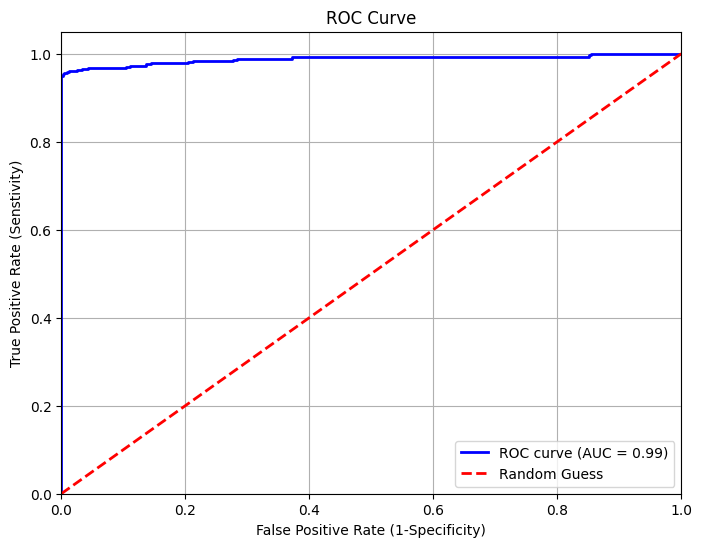

In [19]:
# model = torch.load('saved_models/distinct_R_S_mutations_synth_seed42_2024_10_17_203656')
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)

In [21]:
evaluation.calculate_sens_spec(model, model.test_loader)
# calculate_sens_spec(model, test_loader)

Number predicted resistant = 477. Number labeled R = 498
Number predicted susceptible = 523. Number labeled S = 502
Sensitivity: 0.95
Specificity: 1.00


(0.9538152610441767, 0.9960159362549801)

In [ ]:
# some of the resistant mutations are from mutagenesis studies (yaddon)
# train/test set was constructed from lists of mutations from yaddon and 2x catalogues, with conflicts removed
# not constructed from real data
# for simple ML paper, validation set was created from cryptic with 'football score' method

# can either try with cryptic real data (either all of the samples, or pick the unique alleles [ie. where there are no conflicts])
# or can do like for like comparison, with created dataset like in simple ML paper

# TODO: construct alleles from MUTATIONS table
# be aware of uniqueID; if multiple rows have the same uniqueID, then there are multiple mutations in the same allele
# can't use promoters, indels etc. (for now?). and get rid of filter fails
# think carefully about how to build the alleles^^ 

### Run synth dataset for full R and S mutations

In [22]:
full_res_list = list(pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='R'].MUTATION.drop_duplicates())
full_sus_list = list(pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='S'].MUTATION.drop_duplicates())
full_res_list = ['pncA@' + x for x in full_res_list]
full_sus_list = ['pncA@' + x for x in full_sus_list]
print(len(full_res_list))
print(len(full_sus_list))

349
315


In [23]:
# use sbmlsim

batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations=full_res_list,
                        susceptible_mutations=full_sus_list,
                        genbank_file='/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk'
                    )

In [24]:
seed = 50
np.random.seed(seed)
random.seed(seed)

full_r_synth_sequences, full_r_synth_mutations = batch.generate(n_samples=5000,
                                                  proportion_resistant=0.5,
                                                  n_res = 1,
                                                  n_sus = 1)

full_r_synth_sequences.rename(columns = {'pncA':'allele'}, inplace=True)

In [29]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
learning_rate = 0.0001
wd = 5e-5
epochs = 390

# todo: repeats with varying random seeds (for varying train/test split)
# will have to include sbmlsim.generate in the loop, to generate a new dataset with new random seed each time
# todo: tuning


model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=full_r_synth_sequences,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    wt_seq = wt_seq,
    edge_weight_func = 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    # use_wandb = use_wandb,
    normalise_ews=True
)

torch.save(model, f'saved_models/full_R_S_mutations_synth_n_res1_n_sus1_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

100%|██████████| 5000/5000 [00:38<00:00, 130.90it/s]


Epoch: 010, Train Acc: 0.5140, Test Acc: 0.5230, Train Loss: 0.7016, Test Loss: 0.6978
Epoch: 020, Train Acc: 0.5927, Test Acc: 0.5860, Train Loss: 0.6903, Test Loss: 0.6903
Epoch: 030, Train Acc: 0.5990, Test Acc: 0.5920, Train Loss: 0.6890, Test Loss: 0.6890
Epoch: 040, Train Acc: 0.4475, Test Acc: 0.4460, Train Loss: 0.6891, Test Loss: 0.6898
Epoch: 050, Train Acc: 0.4763, Test Acc: 0.4630, Train Loss: 0.6897, Test Loss: 0.6913
Epoch: 060, Train Acc: 0.6340, Test Acc: 0.6430, Train Loss: 0.6851, Test Loss: 0.6852
Epoch: 070, Train Acc: 0.5437, Test Acc: 0.5490, Train Loss: 0.6860, Test Loss: 0.6845
Epoch: 080, Train Acc: 0.4670, Test Acc: 0.4510, Train Loss: 0.6843, Test Loss: 0.6865
Epoch: 090, Train Acc: 0.6100, Test Acc: 0.6110, Train Loss: 0.6778, Test Loss: 0.6779
Epoch: 100, Train Acc: 0.4820, Test Acc: 0.4760, Train Loss: 0.6918, Test Loss: 0.6970
Epoch: 110, Train Acc: 0.6695, Test Acc: 0.6690, Train Loss: 0.6699, Test Loss: 0.6710
Epoch: 120, Train Acc: 0.6747, Test Acc: 0.

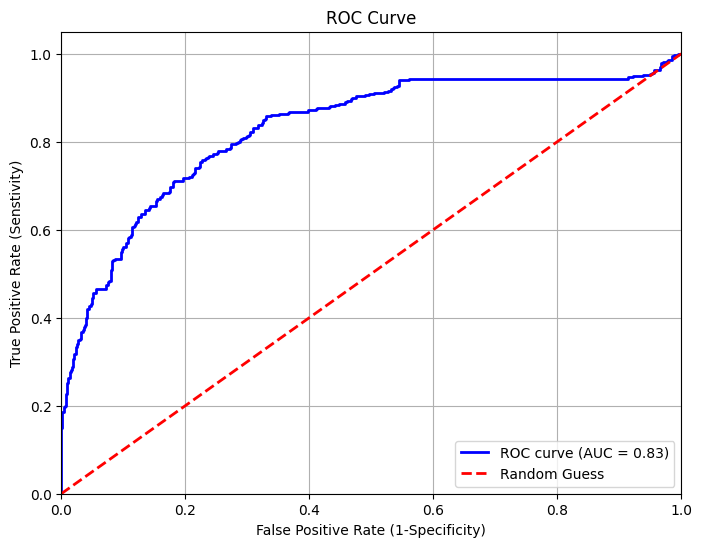

In [30]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)

In [31]:
evaluation.calculate_sens_spec(model, model.test_loader)

Number predicted resistant = 429. Number labeled R = 477
Number predicted susceptible = 571. Number labeled S = 523
Sensitivity: 0.70
Specificity: 0.82


(0.7023060796645703, 0.8202676864244742)

In [135]:
print('Train set')
pd.DataFrame(['R' if int(sample.y) == 1 else 'S' for sample in model.dataset_dict['train']], columns=['phenotype']).value_counts()


Train set


phenotype
S            723
R            677
Name: count, dtype: int64

In [134]:
print('Test set')
pd.DataFrame(['R' if int(sample.y) == 1 else 'S' for sample in model.dataset_dict['test']], columns=['phenotype']).value_counts()


Test set


phenotype
R            153
S            147
Name: count, dtype: int64

### Rerun for cryptic alleles

In [16]:
cryptic_sequences = pd.read_csv('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/cryptic_alleles.csv')
cryptic_sequences

,allele,number_mutations,phenotype_label
0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
2,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
3,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
4,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
...,...,...,...
282,MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
283,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
284,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
285,MRALSIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R


In [19]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
learning_rate = 0.001
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=cryptic_sequences,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    wt_seq = wt_seq,
    edge_weight_func = 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    # use_wandb = use_wandb,
    normalise_ews=True
)

# torch.save(model, f'saved_models/distinct_mutations_synth_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

100%|██████████| 287/287 [00:02<00:00, 135.87it/s]


Epoch: 010, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.7303, Test Loss: 0.5700
Epoch: 020, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6652, Test Loss: 0.6346
Epoch: 030, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6702, Test Loss: 0.6070
Epoch: 040, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6808, Test Loss: 0.6364
Epoch: 050, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6642, Test Loss: 0.6465
Epoch: 060, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6708, Test Loss: 0.6149
Epoch: 070, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6905, Test Loss: 0.6228
Epoch: 080, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6618, Test Loss: 0.6222
Epoch: 090, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6629, Test Loss: 0.6276
Epoch: 100, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6707, Test Loss: 0.6204
Epoch: 110, Train Acc: 0.6000, Test Acc: 0.7442, Train Loss: 0.6703, Test Loss: 0.6147
Epoch: 120, Train Acc: 0.6000, Test Acc: 0.

### Rerun for real dataset

In [20]:
sequences

,phenotype_label,number_resistant_mutations,number_susceptible_mutations,allele
0,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
1,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
2,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
3,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
4,R,1,0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
...,...,...,...,...
659,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
660,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
661,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...
662,S,0,1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...


In [22]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
learning_rate = 0.0001
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=sequences,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    wt_seq = wt_seq,
    edge_weight_func = 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    # use_wandb = use_wandb,
    normalise_ews=True
)

# torch.save(model, f'saved_models/distinct_mutations_synth_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

100%|██████████| 664/664 [00:04<00:00, 138.73it/s]


Epoch: 010, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6910, Test Loss: 0.6924
Epoch: 020, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6903, Test Loss: 0.6921
Epoch: 030, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6940, Test Loss: 0.6922
Epoch: 040, Train Acc: 0.5000, Test Acc: 0.5400, Train Loss: 0.6928, Test Loss: 0.6929
Epoch: 050, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6927, Test Loss: 0.6924
Epoch: 060, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6909, Test Loss: 0.6926
Epoch: 070, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6921, Test Loss: 0.6923
Epoch: 080, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6909, Test Loss: 0.6923
Epoch: 090, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6945, Test Loss: 0.6930
Epoch: 100, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6925, Test Loss: 0.6923
Epoch: 110, Train Acc: 0.5237, Test Acc: 0.5400, Train Loss: 0.6888, Test Loss: 0.6925
Epoch: 120, Train Acc: 0.5237, Test Acc: 0.

In [ ]:
# 01/10/2024 summary
"""
So far real sample datasets have not worked. I think this is because they have
S alleles with mutations at the same positions as R alleles. Some things to try:
1. try running `sequences` (the real dataset from pnca paper) but remove any S 
alleles that have mutations that appear in R alleles. So a full list of R alleles
but some S alleles will be removed.
2. Try `synth_sequences` but generate them with the full list of R mutations. So
the dataset will have all the R mutations from the pnca paper.

3. Set up toy scenario (like with mutations selected around active site). 
Artificially assign R and S mutations at the same position. Make it clear what 
chemical properties of the residue correspond to R and S. eg. At a given position; 
bulky hydrophobic change is R / small hydrophilic change is S etc.

Things to check in sbmlsim:
1. When it assigns S mutations, does it ignore the positions that have R mutations?
Or can it still assign a different amino acid change to a position where an R 
has been defined.
1b. Should we have an option where it can put in S mutations in the same positions
as R mutations?

2. Look into implementing a way we can define S mutations when generating sequences.

"""

In [ ]:
# use exponential distance weighting; tune for the exponent

# try synthetic dataset with scrambled graph (randomise edge index)

# try different hyperparameters / batch size

# closest distance to drug

# do heterograph on pnca

# local equivariance in message passing (SE3), followed by invariant global pooling
# When caculating embedding of a node, the order in which the neighbour nodes are aggregated
# should matter. Currently (in the invariant GCN) we lose this geometric information in the
# node representation.

In [ ]:
# tenfold cross validation